In [134]:
from sklearn.impute import SimpleImputer
from imblearn.over_sampling import SMOTENC
from imblearn.under_sampling import RandomUnderSampler
from collections import Counter
from sklearn.preprocessing import LabelEncoder
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
import pandas as pd
import numpy as np
from sklearn.metrics import confusion_matrix, classification_report, ConfusionMatrixDisplay
import matplotlib.pyplot as plt
import plt

In [43]:
folders = ["2013-2014", "2017-2020"]
files = ["OSQ", "DEMO", "BMX", "ALQ", "BIOPRO", "DR1TOT", "PAQ", "RHQ"]
codes = ['SEQN', 'OSQ060', 'ALQ121', 'ALQ130', 'RHD043', 'RHQ060', 'PAD615', 'PAD660', 'PAD675', 'PAD680', 'PAD645',
         'RIDAGEYR', 'RIAGENDR', 'RIDRETH3', 'BMXBMI', 'DR1TVD', 'DR1TCALC', 'LBXSCA']
labels_mapping = {
    'SEQN': 'patient',
    'OSQ060': 'osteoporosis',
    'ALQ121': 'alcohol past 12 mos',
    'ALQ130': 'avg alcohol/day past 12 mos',
    'RHD043': 'menopause',
    'RHQ060': 'age of last period',
    'PAD615': 'physical work (min)',
    'PAD660': 'vigorous exercise (min)',
    'PAD675': 'moderate exercise (min)',
    'PAD680': 'sedentary (min)',
    'PAD645': 'walk/bike (min)',
    'RIDAGEYR': 'age',
    'RIAGENDR': 'gender',
    'RIDRETH3': 'ethnicity',
    'BMXBMI': 'BMI',
    'DR1TVD': 'vit.D intake',
    'DR1TCALC': 'calcium intake',
    'LBXSCA': 'total calcium mg/dL'
}

data = pd.DataFrame(
    columns=['patient', 'osteoporosis', 'age', 'gender', 'ethnicity', 'BMI', 'menopause', 'age of last period',
             'vit.D intake', 'calcium intake', 'total calcium mg/dL', 'alcohol past 12 mos',
             'avg alcohol/day past 12 mos', 'physical work (min)', 'vigorous exercise (min)', 'moderate exercise (min)',
             'sedentary (min)', 'walk/bike (min)'])
for folder in folders:
    for file in files:
        file_path = f"{folder}/{file}.xpt"
        df = pd.read_sas(file_path, format="xport")
        filtered = df.filter(items=codes)
        filtered.rename(columns=labels_mapping, inplace=True)
        data = pd.concat([data, filtered], ignore_index=True)
        data = data.groupby('patient', as_index=False).first()



C:\Users\omord\AppData\Local\Temp\ipykernel_24636\1463285960.py:37: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  data = pd.concat([data, filtered], ignore_index=True)
C:\Users\omord\AppData\Local\Temp\ipykernel_24636\1463285960.py:37: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  data = pd.concat([data, filtered], ignore_index=True)
C:\Users\omord\AppData\Local\Temp\ipykernel_24636\1463285960.py:37: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecate

In [101]:
# data.dropna(axis=0, how='any', inplace=True)
data = data.dropna(
    subset=["osteoporosis", "vit.D intake", "calcium intake", "total calcium mg/dL", "age", "gender", "ethnicity",
            "BMI", "alcohol past 12 mos"])
data = data.dropna(thresh=10)

data.dropna(subset=['osteoporosis'], inplace=True)
data = data[data['osteoporosis'].isin([1, 2])]
data['menopause'] = data['menopause'].fillna(0)  # !!! turned missing data to 0
data = data[data['menopause'].isin([3, 7, 0])]
data['osteoporosis'] = data['osteoporosis'].map({1: 1, 2: 0})
print(data.shape)
print(data['osteoporosis'].unique())
data
# 
# patient_rows = data[data['patient'] == 109290.0]
# patient_rows
data = data.drop(columns=['patient'])
data = data[~data['age of last period'].isin([777, 999])]
instance = data.copy()
# unique values for cathegoricals
columns_to_check = ['gender', 'ethnicity', 'menopause']

for col in columns_to_check:
    print(f"{col}: {data[col].unique()}")



(366, 17)
[1]


KeyError: "['patient'] not found in axis"

In [102]:
numeric_cols = [c for c in instance.columns if instance[c].dtype in ['int64', 'float64'] and c != 'osteoporosis']

# Fit and transform
num_imputer = SimpleImputer(strategy='median')
numeric_imputed = num_imputer.fit_transform(instance[numeric_cols])

# Assign back safely
instance[numeric_cols] = pd.DataFrame(numeric_imputed, columns=numeric_cols, index=instance.index)

# The target column stays untouched
print("Imputation done. Shape:", instance.shape)
for i in numeric_cols:
    print(i, instance[i].isna().sum())

print(instance['ethnicity'].unique())

instance.head()
# cat_columns = ['gender', 'ethnicity','menopause']
# 
# 
# valid_values = {
#     'gender': [1, 2],
#     'ethnicity': [1,2,3,4,6,7],
#     'menopause': [0,7,9]
# }
# 
# for col in cat_columns:
#     instance[col] = instance[col].apply(lambda x: x if x in valid_values[col] else -1)
#     instance[col] = instance[col].fillna(-1)
# encoding gender ethnicity and menopause values to match the 0-N format


Imputation done. Shape: (3261, 17)
age 0
gender 0
ethnicity 0
BMI 0
menopause 0
age of last period 0
vit.D intake 0
calcium intake 0
total calcium mg/dL 0
alcohol past 12 mos 0
avg alcohol/day past 12 mos 0
physical work (min) 0
vigorous exercise (min) 0
moderate exercise (min) 0
sedentary (min) 0
walk/bike (min) 0
[5. 2. 3. 4. 0. 1.]


,osteoporosis,age,gender,ethnicity,BMI,menopause,age of last period,vit.D intake,calcium intake,total calcium mg/dL,alcohol past 12 mos,avg alcohol/day past 12 mos,physical work (min),vigorous exercise (min),moderate exercise (min),sedentary (min),walk/bike (min)
10186,0,68.0,0.0,5.0,30.2,0.0,48.0,4.6,1309.0,9.1,4.000000e+00,2.0,480.0,60.0,60.0,300.0,60.0
10194,0,76.0,0.0,2.0,26.6,0.0,48.0,0.9,770.0,9.1,5.397605e-79,2.0,120.0,60.0,45.0,900.0,30.0
10202,0,68.0,1.0,3.0,28.1,2.0,45.0,4.1,409.0,9.9,5.397605e-79,2.0,120.0,60.0,90.0,180.0,30.0
10210,0,68.0,0.0,2.0,34.2,0.0,48.0,0.4,160.0,9.4,5.397605e-79,2.0,120.0,60.0,45.0,120.0,30.0
10212,0,54.0,1.0,4.0,29.6,1.0,50.0,0.4,155.0,9.0,5.397605e-79,2.0,120.0,60.0,45.0,60.0,30.0


In [103]:
categorical_cols = ['gender', 'ethnicity', 'menopause']
encoders = {}

# Encode to 0..N
for col in categorical_cols:
    le = LabelEncoder()
    instance[col] = le.fit_transform(instance[col])
    encoders[col] = le

    mapping = dict(zip(le.classes_, le.transform(le.classes_)))
    print(f"Column: {col}")
    print(mapping)

# OLD VALUES
## Male - 1 | Female - 2
## Mexican American - 1 | Other Hispanic - 2 | Non-Hispanic White - 3 | Non-Hispanic Black - 4 | 
## Non-Hispanic Asian - 6 | Other Race - Including Multi-Racial - 7
## NaN - 0 | Hysterectomy - 3 | Menopause - 7

# NEW VALUES
## Male - 0 | Female - 1
## Mexican American - 0 | Other Hispanic - 1 | Non-Hispanic White - 2 | Non-Hispanic Black - 3 | 
## Non-Hispanic Asian - 4 | Other Race - Including Multi-Racial - 5
## NaN - 0 | Hysterectomy - 1 | Menopause - 2

Column: gender
{np.float64(0.0): np.int64(0), np.float64(1.0): np.int64(1)}
Column: ethnicity
{np.float64(0.0): np.int64(0), np.float64(1.0): np.int64(1), np.float64(2.0): np.int64(2), np.float64(3.0): np.int64(3), np.float64(4.0): np.int64(4), np.float64(5.0): np.int64(5)}
Column: menopause
{np.float64(0.0): np.int64(0), np.float64(1.0): np.int64(1), np.float64(2.0): np.int64(2)}


In [104]:
men = instance[instance['gender'] == 0].copy()
women = instance[instance['gender'] == 1].copy()

In [119]:
def balance(instance):
    numeric_cols = [c for c in instance.columns 
                if c not in categorical_cols + ['osteoporosis']]
    
    cat_idx = [instance.columns.get_loc(col) for col in categorical_cols]
    
    smote_nc = SMOTENC(
        categorical_features=cat_idx,
        sampling_strategy={1: 800},
        random_state=42
    )
    
    X = instance.drop(columns=['osteoporosis'])
    y = instance['osteoporosis']
    
    X_res, y_res = smote_nc.fit_resample(X, y)
    print("After SMOTENC:", Counter(y_res))
    
    # undersampling negatives
    rus = RandomUnderSampler(sampling_strategy={0: 800}, random_state=42)  # 0 = negative class
    X_final, y_final = rus.fit_resample(X_res, y_res)
    X_final['age'] = X_final['age'].round().astype(int)
    # X_final['BMI'] = X_final['weight'] / ( (X_final['height'] / 100) ** 2 )
    print("After Under Samplings:", Counter(y_final))
    
    instance_balanced = pd.concat([X_final, y_final], axis=1)
    print(instance_balanced.shape)
    instance_balanced.head()
    
    return instance_balanced

In [120]:
def train_model(instance_balanced, label=""):
    X = instance_balanced.drop(columns=['osteoporosis'])
    y = instance_balanced['osteoporosis']
    
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=0.2, stratify=y, random_state=42
    )
    
    neg_size = (instance_balanced['osteoporosis'] == 0).sum()
    pos_size = (instance_balanced['osteoporosis'] == 1).sum()
    ratio = neg_size / pos_size
    
    model = RandomForestClassifier(
    n_estimators=200,
    class_weight = {0: 1, 1: ratio},
    random_state=42
    )
    model.fit(X_train, y_train)
    
    print("\n")
    print(f"==Importances ({label})==")
    importances = model.feature_importances_
    indices = np.argsort(importances)[::-1]
    
    for i in indices[:20]:
        print(X.columns[i], importances[i])

    return model, X_test, y_test   
    

In [121]:
def predict(model, X_test, y_test, threshold = 0.35):
    probs = model.predict_proba(X_test)[:, 1]
    y_pred_thr = np.where(probs >= threshold, 1, 0)
    cm = confusion_matrix(y_test, y_pred_thr)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=model.classes_)
    disp.plot(cmap='Blues')
    plt.show()
    print(classification_report(y_test, y_pred_thr))

In [122]:
men_balanced = balance(men)
women_balanced = balance(women)

After SMOTENC: Counter({0: 1703, 1: 800})
After Under Samplings: Counter({0: 800, 1: 800})
(1600, 17)
After SMOTENC: Counter({0: 1192, 1: 800})
After Under Samplings: Counter({0: 800, 1: 800})
(1600, 17)


In [123]:
men_balanced = men_balanced.drop(
    columns=['menopause', 'age of last period'],
    errors='ignore'
)

In [124]:
men_model, X_test_men, y_test_men = train_model(men_balanced, "men")
women_model, X_test_women, y_test_women = train_model(women_balanced, "women")



==Importances (men)==
age 0.1312396645896992
avg alcohol/day past 12 mos 0.11026817057853179
calcium intake 0.10078186489648598
alcohol past 12 mos 0.09732214335518181
vit.D intake 0.08694834304840239
moderate exercise (min) 0.07773389023441175
BMI 0.07767706496279633
total calcium mg/dL 0.0748112583591109
sedentary (min) 0.07247564498677893
ethnicity 0.07201830686124634
physical work (min) 0.041824854731162285
walk/bike (min) 0.028714326287388507
vigorous exercise (min) 0.028184467108803825
gender 0.0


==Importances (women)==
age 0.1499978507235236
calcium intake 0.11279023194310098
vit.D intake 0.08671970445910258
BMI 0.08411306843081688
age of last period 0.08068553962925307
total calcium mg/dL 0.07534273780735781
avg alcohol/day past 12 mos 0.06994248857198423
ethnicity 0.06991555046021922
sedentary (min) 0.06917894105551492
alcohol past 12 mos 0.0660485073232721
moderate exercise (min) 0.04675408376296986
menopause 0.033802588228717054
physical work (min) 0.024520138082891507
w

=== MEN MODEL ===


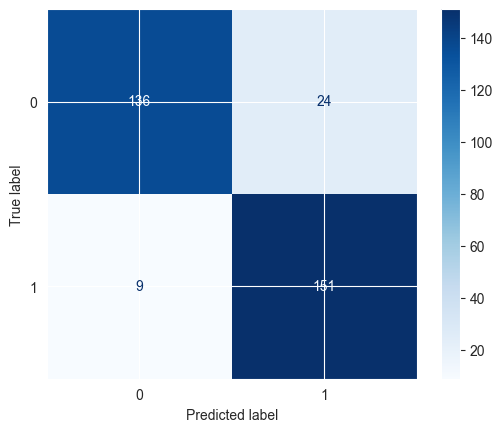

              precision    recall  f1-score   support

           0       0.94      0.85      0.89       160
           1       0.86      0.94      0.90       160

    accuracy                           0.90       320
   macro avg       0.90      0.90      0.90       320
weighted avg       0.90      0.90      0.90       320

=== WOMEN MODEL ===


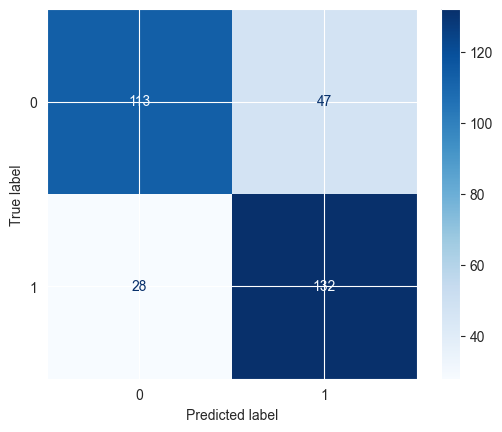

              precision    recall  f1-score   support

           0       0.80      0.71      0.75       160
           1       0.74      0.82      0.78       160

    accuracy                           0.77       320
   macro avg       0.77      0.77      0.76       320
weighted avg       0.77      0.77      0.76       320



In [133]:
print("=== MEN MODEL ===")
predict(men_model, X_test_men, y_test_men, 0.35)

print("=== WOMEN MODEL ===")
predict(women_model, X_test_women, y_test_women, 0.45)
